# AMS and f(RH) Time Series

Import functions

In [1]:
from funcs import * # funcs include functions used across scripts
import pandas as pd
from matplotlib import pyplot as plt

Read in the data

In [2]:
o = read_all('OPTICAL') # optical data
inl = read_all('InletFlag') # inlet flag
a = read_all('AMS') # ams
mn = read_all('MetNav') # met nav

Code used to plot a variable over the course of the entire campaign

In [3]:
def remove_nan(d, var):
    return d[np.isfinite(d[var])].reset_index(drop=True)

In [4]:
def add_line(x,y):
    m , b = np.polyfit(x, y, 1)
    x2 = np.linspace(x.min(), x.max(), 1000)
    y2 = x2*m + b
    return x2,y2

In [10]:
def var_plot(d, var, var_label):
    fig,ax = plt.subplots(figsize=(9,3))

    d_resamp = d.resample('2h', on='Time_Mid').quantile(.50).reset_index()
    d_resamp_75 = d.resample('2h', on='Time_Mid').quantile(.75).reset_index()
    d_resamp_25 = d.resample('2h', on='Time_Mid').quantile(.25).reset_index()

    d_resamp = remove_nan(d_resamp, var)
    d_resamp_25 = remove_nan(d_resamp_25, var)
    d_resamp_75 = remove_nan(d_resamp_75, var)

    
    ax.errorbar(d_resamp.index, d_resamp[var], yerr=(d_resamp_75[var]-d_resamp[var], d_resamp[var]-d_resamp_25[var]), c='black', fmt='.')
    #plt.plot(d_resamp.index, d_resamp[var])

    x,y = add_line(d_resamp.index,d_resamp[var])
    plt.plot(x,y, ls = '--', c='red')


    day_changes = d_resamp['Time_Mid'].dt.date.diff().ne(pd.Timedelta(0))
    flight_ind = list(d_resamp[day_changes].index)
    day_ticks = []
    for i in range(0,len(flight_ind)):
        ax.axvline(flight_ind[i], 0, 1, alpha=.2, c='black')
        date = d_resamp.loc[flight_ind[i]]['Time_Mid']
        day_ticks.append(str(date.month) + '/' + str(date.day))

    ax.set_xticks(flight_ind)
    ax.set_xticklabels(day_ticks, rotation=90)
    ax.set_xlabel('Date [M/DD]')
    ax.set_ylabel(var_label)

    fig.tight_layout()
    fig.savefig('../figures/timeline_'+var+'.png', dpi=300)

TypeError: GroupBy.quantile() got an unexpected keyword argument 'ignorenan'

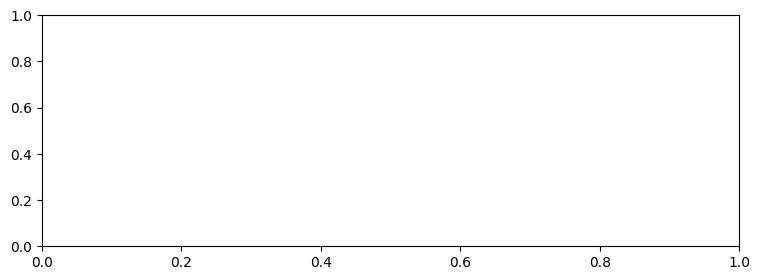

In [11]:
var_plot(o,'fRH550_RH20to80', 'f(RH)')

In [7]:
ams_keys = ['Org_Ave_IsoK_STP','SO4_Ave_IsoK_STP','NO3_Ave_IsoK_STP','NH4_Ave_IsoK_STP','Chl_Ave_IsoK_STP']
a['tot'] = a[ams_keys].sum(axis=1)
a['OMF'] = a['Org_Ave_IsoK_STP']/a['tot']
a['SMF'] = a['SO4_Ave_IsoK_STP']/a['tot']

/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/pandas/core/groupby/groupby.py:4478: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/pandas/core/groupby/groupby.py:4478: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/pandas/core/groupby/groupby.py:4478: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(


83 83 83


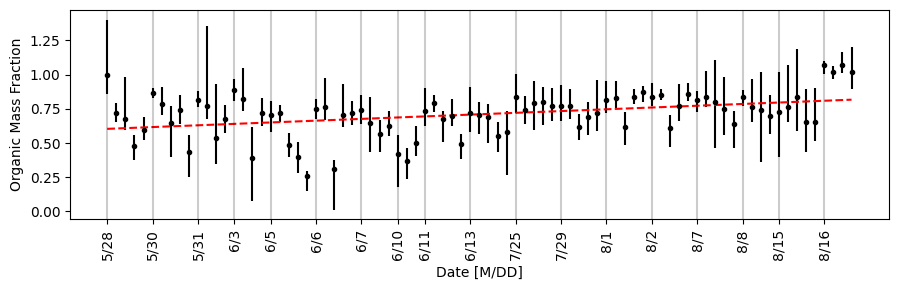

In [8]:
var_plot(a, 'OMF', 'Organic Mass Fraction')

/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/pandas/core/groupby/groupby.py:4478: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/pandas/core/groupby/groupby.py:4478: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(
/Users/cassidysoloff/Documents/git/ARCSIX_DASH/.venv/lib/python3.13/site-packages/pandas/core/groupby/groupby.py:4478: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(


83 83 83


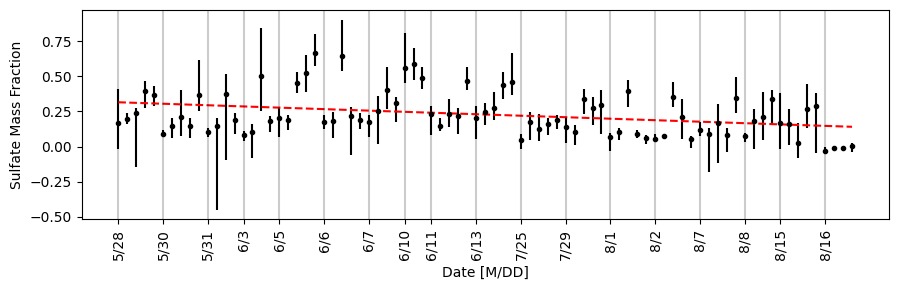

In [9]:
var_plot(a, 'SMF', 'Sulfate Mass Fraction')